In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import sys
import os
sys.path.append(os.path.abspath(os.path.join('..')))

import numpy as np

from sed_scores_eval import intersection_based

import glob
import os
import time

import datasets
import evaluate
import matplotlib.pyplot as plt



results shape:  (4, 5, 8)
results shape:  (4, 5, 8)


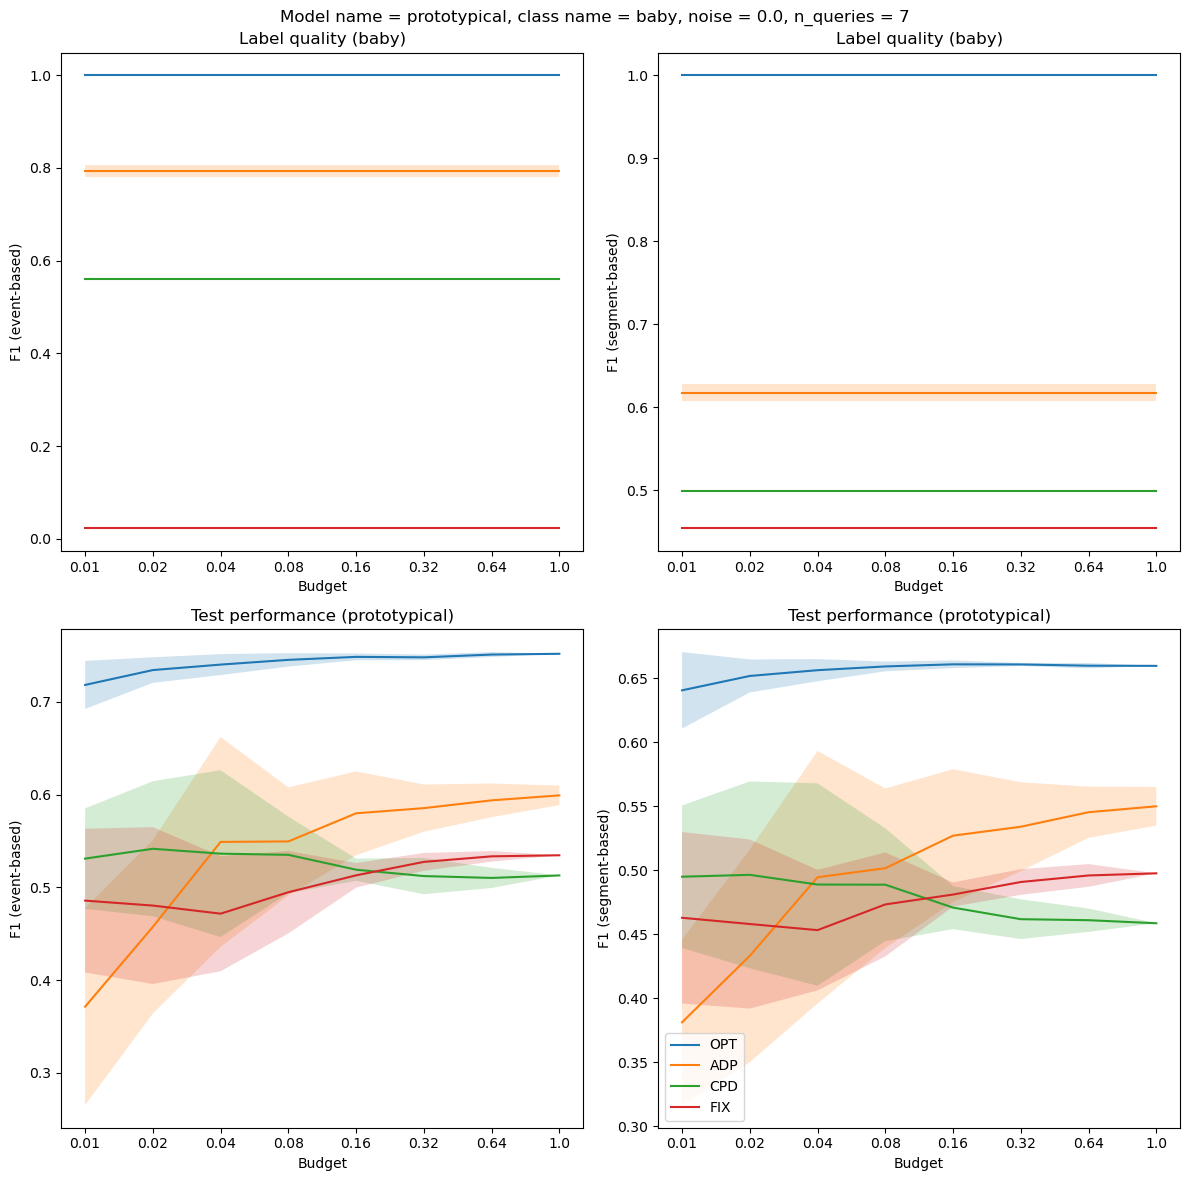

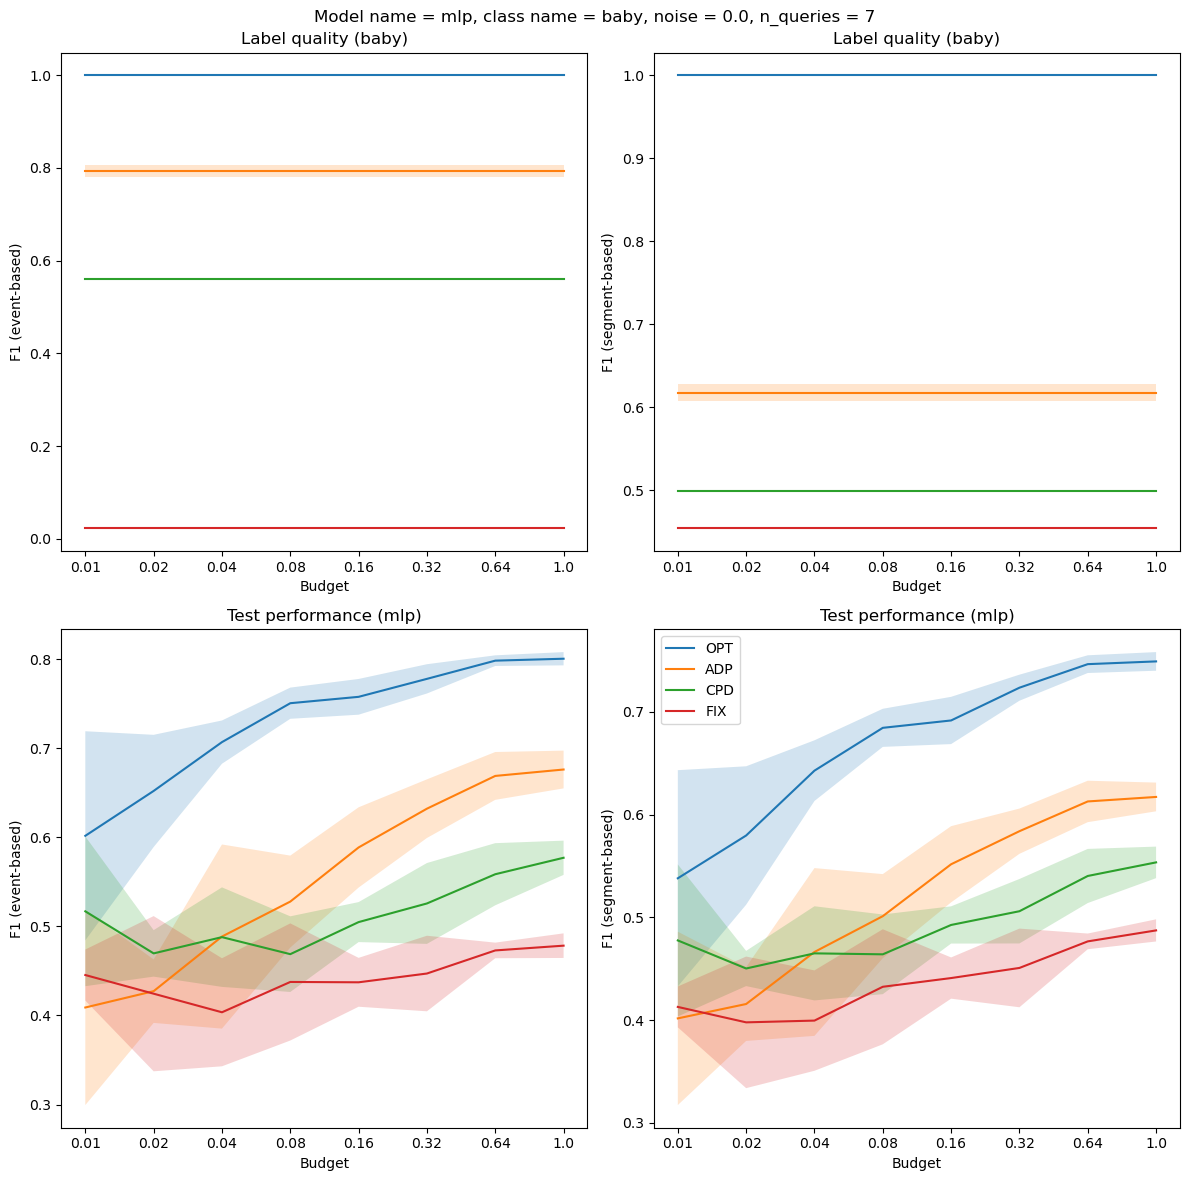

In [2]:
# results are saved as
# np.save(os.path.join(sim_dir, '{}_{}_f1_event_based_train_results.npy'.format(model_name, method_name)), f1_event_based_train_results)
# np.save(os.path.join(sim_dir, '{}_{}_f1_segment_based_train_results.npy'.format(model_name, method_name)), f1_segment_based_train_results)
# np.save(os.path.join(sim_dir, '{}_{}_f1_event_based_test_results.npy'.format(model_name, method_name)), f1_event_based_test_results)
# np.save(os.path.join(sim_dir, '{}_{}_f1_segment_based_test_results.npy'.format(model_name, method_name)), f1_segment_based_test_results)
#
# produce figure loads the results for each model_name and method_name and plots f1_event_based_train results in one plot, f1_segment_based_train results in another plot, f1_event_based_test results in another plot, and f1_segment_based_test results in another plot.
# method_name and model_name are part of the legend in the plot
method_names = ['OPT', 'ADP', 'CPD', 'FIX']
def produce_figure(result_dir, n_queries, noise, class_name, save_dir):
    sim_dir = os.path.join(result_dir, 'n_queries_{}_noise_{}/'.format(n_queries, noise))
    for model_name in ['prototypical', 'mlp']:
        f1_event_based_train_results = np.load(os.path.join(sim_dir, '{}_f1_event_based_train_results.npy'.format(model_name)))
        f1_segment_based_train_results = np.load(os.path.join(sim_dir, '{}_f1_segment_based_train_results.npy'.format(model_name)))
        f1_event_based_test_results = np.load(os.path.join(sim_dir, '{}_f1_event_based_test_results.npy'.format(model_name)))
        f1_segment_based_test_results = np.load(os.path.join(sim_dir, '{}_f1_segment_based_test_results.npy'.format(model_name)))
        print("results shape: ", f1_event_based_train_results.shape)

        results = [f1_event_based_train_results, f1_segment_based_train_results, f1_event_based_test_results, f1_segment_based_test_results]

        # results arrays have shape (n_methods, n_runs, n_budgets)
        # we want to plot the mean and std over runs, for each method, with budget on the x-axis
        # so we want to plot the mean and std over axis 1

        suptitle = "Model name = {}, class name = {}, noise = {}, n_queries = {}".format(model_name, class_name, noise, n_queries)
        fig, ax = plt.subplots(2, 2, figsize=(12, 12))
        for idx_result, result in enumerate(results):
            for idx_method in range(4):
                y = np.mean(result[idx_method], axis=0)
                yerr = np.std(result[idx_method], axis=0)
                ax[idx_result // 2, idx_result % 2].plot(y, label=method_names[idx_method])
                ax[idx_result // 2, idx_result % 2].fill_between(np.arange(len(y)), y - yerr, y + yerr, alpha=0.2)
                ax[idx_result // 2, idx_result % 2].set_xlabel('Budget')
                if idx_result % 2 == 0:
                    ax[idx_result // 2, idx_result % 2].set_ylabel('F1 (event-based)')
                else:
                    ax[idx_result // 2, idx_result % 2].set_ylabel('F1 (segment-based)')

        budgets = [0.01, 0.02, 0.04, 0.08, 0.16, 0.32, 0.64, 1.0]
        for xs in ax:
            for a in xs:
                a.set_xticks(np.arange(len(budgets)))
                a.set_xticklabels(budgets)
        ax[0,0].set_title('Label quality ({})'.format(class_name))
        ax[0,1].set_title('Label quality ({})'.format(class_name))
        ax[1,0].set_title('Test performance ({})'.format(model_name))
        ax[1,1].set_title('Test performance ({})'.format(model_name))
        
        plt.suptitle(suptitle)
        plt.tight_layout()
        plt.legend()
        
class_name = 'dog'
produce_figure(result_dir='../results/5_runs/{}/'.format(class_name), n_queries=7, noise=0.0, class_name='baby', save_dir=None)
#produce_figure(result_dir='../results/5_runs/me/', n_queries=7, noise=0.25, class_name='me', save_dir=None)
#produce_figure(result_dir='../results/5_runs/me/', n_queries=20, noise=0.0, class_name='me', save_dir=None)
#produce_figure(result_dir='../results/5_runs/me/', n_queries=20, noise=0.25, class_name='me', save_dir=None)

model_name: prototypical, n_queries: 7, noise: 0.0, class_name: baby
model_name: prototypical, n_queries: 10, noise: 0.0, class_name: baby
model_name: prototypical, n_queries: 15, noise: 0.0, class_name: baby
model_name: prototypical, n_queries: 20, noise: 0.0, class_name: baby
model_name: prototypical, n_queries: 25, noise: 0.0, class_name: baby
model_name: prototypical, n_queries: 30, noise: 0.0, class_name: baby
model_name: mlp, n_queries: 7, noise: 0.0, class_name: baby
model_name: mlp, n_queries: 10, noise: 0.0, class_name: baby
model_name: mlp, n_queries: 15, noise: 0.0, class_name: baby
model_name: mlp, n_queries: 20, noise: 0.0, class_name: baby
model_name: mlp, n_queries: 25, noise: 0.0, class_name: baby
model_name: mlp, n_queries: 30, noise: 0.0, class_name: baby


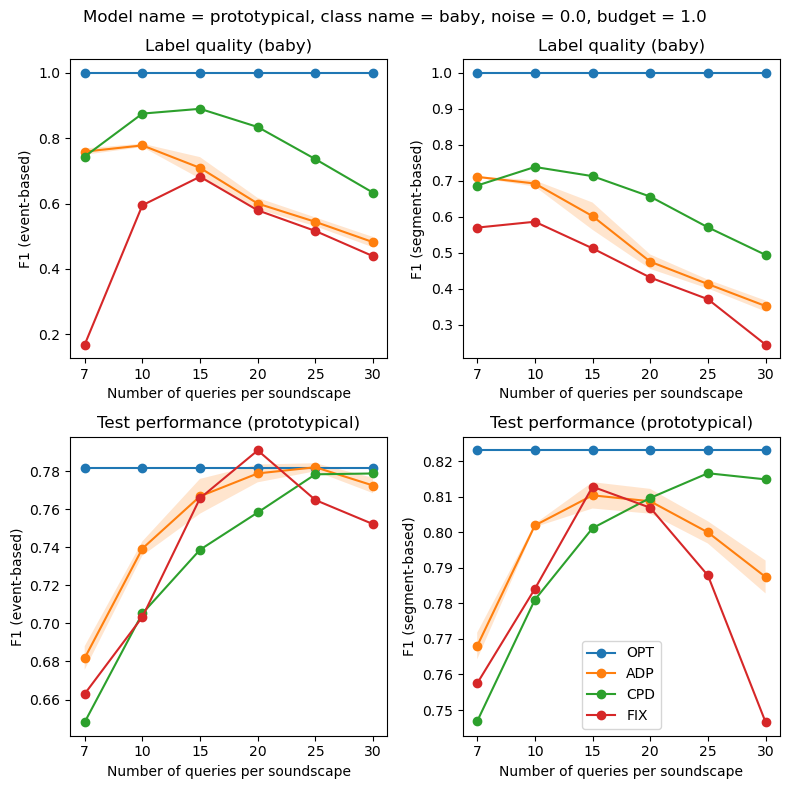

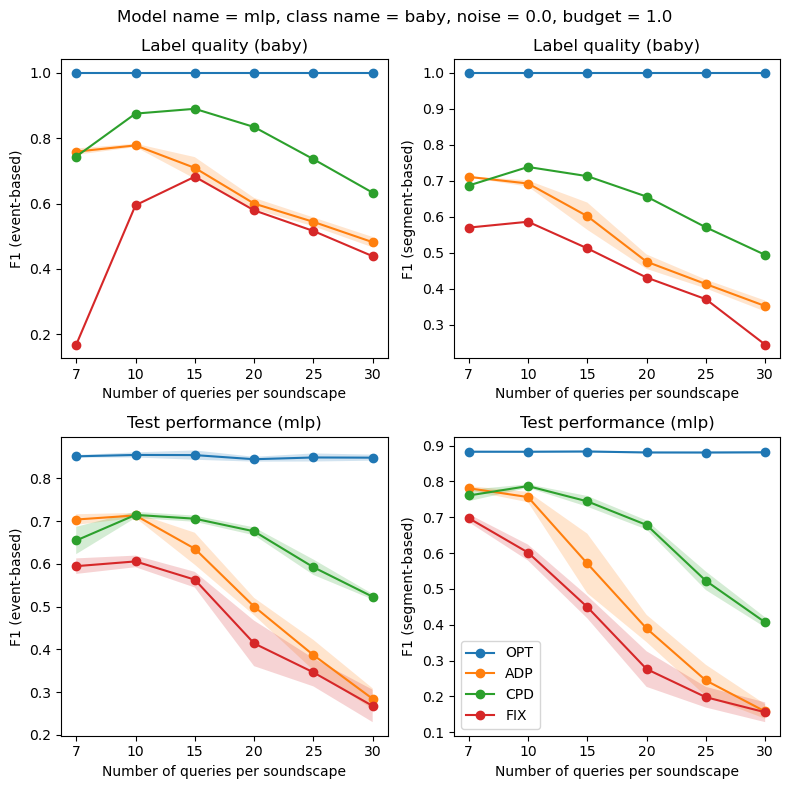

In [7]:
# results are saved as
# np.save(os.path.join(sim_dir, '{}_{}_f1_event_based_train_results.npy'.format(model_name, method_name)), f1_event_based_train_results)
# np.save(os.path.join(sim_dir, '{}_{}_f1_segment_based_train_results.npy'.format(model_name, method_name)), f1_segment_based_train_results)
# np.save(os.path.join(sim_dir, '{}_{}_f1_event_based_test_results.npy'.format(model_name, method_name)), f1_event_based_test_results)
# np.save(os.path.join(sim_dir, '{}_{}_f1_segment_based_test_results.npy'.format(model_name, method_name)), f1_segment_based_test_results)
#
# produce figure loads the results for each model_name and method_name and plots f1_event_based_train results in one plot, f1_segment_based_train results in another plot, f1_event_based_test results in another plot, and f1_segment_based_test results in another plot.
# method_name and model_name are part of the legend in the plot



# TODO: this does not seem to do what I want.
def produce_figure_f1_vs_n_queries(result_dir, noise, class_name, n_queriess, budget, save_dir=None):
    method_names = ['OPT', 'ADP', 'CPD', 'FIX']
    for model_name in ['prototypical', 'mlp']:
            resultss = []
            for n_queries in n_queriess:
                sim_dir = os.path.join(result_dir, 'n_queries_{}_noise_{}/'.format(n_queries, noise))
                print("model_name: {}, n_queries: {}, noise: {}, class_name: {}".format(model_name, n_queries, noise, class_name))
                
                f1_event_based_train_results = np.load(os.path.join(sim_dir, '{}_f1_event_based_train_results.npy'.format(model_name)))
                f1_segment_based_train_results = np.load(os.path.join(sim_dir, '{}_f1_segment_based_train_results.npy'.format(model_name)))
                f1_event_based_test_results = np.load(os.path.join(sim_dir, '{}_f1_event_based_test_results.npy'.format(model_name)))
                f1_segment_based_test_results = np.load(os.path.join(sim_dir, '{}_f1_segment_based_test_results.npy'.format(model_name)))

                #print(f1_event_based_train_results.shape)
                #idx_method = 3
                #method_name = method_names[idx_method]
                #print("mean train f1: ", f1_event_based_train_results[idx_method].mean())


                resultss.append([f1_event_based_train_results, f1_segment_based_train_results, f1_event_based_test_results, f1_segment_based_test_results])


            # results arrays have shape (n_methods, n_runs, n_budgets)
            # we want to plot the mean and std over runs, for each method, with budget on the x-axis
            # so we want to plot the mean and std over axis 1

            suptitle = "Model name = {}, class name = {}, noise = {}, budget = {}".format(model_name, class_name, noise, budget)
            fig, ax = plt.subplots(2, 2, figsize=(8, 8))
            for idx_method in range(4):
                for idx_result in range(4):
                    result = [r[idx_result] for r in resultss]
                    #print(len(result))
                    method_result = np.array([r[idx_method] for r in result])
                    #print(method_result.shape)

                    

                    y = np.mean(method_result, axis=1).squeeze()
                    yerr = np.std(method_result, axis=1).squeeze()

                    ax[idx_result // 2, idx_result % 2].plot(y, label=method_names[idx_method], marker='o')
                    ax[idx_result // 2, idx_result % 2].fill_between(np.arange(len(y)), y - yerr, y + yerr, alpha=0.2)
                    ax[idx_result // 2, idx_result % 2].set_xlabel('Number of queries per soundscape')
                    if idx_result % 2 == 0:
                        ax[idx_result // 2, idx_result % 2].set_ylabel('F1 (event-based)')
                    else:
                        ax[idx_result // 2, idx_result % 2].set_ylabel('F1 (segment-based)')

            for xs in ax:
                for a in xs:
                    a.set_xticks(np.arange(len(n_queriess)))
                    a.set_xticklabels(n_queriess)
            ax[0,0].set_title('Label quality ({})'.format(class_name))
            ax[0,1].set_title('Label quality ({})'.format(class_name))
            ax[1,0].set_title('Test performance ({})'.format(model_name))
            ax[1,1].set_title('Test performance ({})'.format(model_name))
            
            plt.suptitle(suptitle)
            plt.tight_layout()
            plt.legend()

n_queriess = [7, 10, 15, 20, 25, 30] #, 35, 40]
budget = 1.0
class_name = 'baby'
produce_figure_f1_vs_n_queries(result_dir='../results/coverage_99/5_runs/{}/'.format(class_name), noise=0.0, class_name=class_name, n_queriess=n_queriess, budget=budget, save_dir=None)
#produce_figure(result_dir='../results/5_runs/me/', n_queries=7, noise=0.25, class_name='me', save_dir=None)
#produce_figure(result_dir='../results/5_runs/me/', n_queries=20, noise=0.0, class_name='me', save_dir=None)
#produce_figure(result_dir='../results/5_runs/me/', n_queries=20, noise=0.25, class_name='me', save_dir=None)

# Derive the training scores for the training data

In [14]:
# test evaluation of the annotations to better understand the metric

# extract nonoverlapping timings with label and create train_scores.tsv
# 
# onset   offset   class1
# 1.0     2.0      0 
# 2.0     3.0      1
# (et cetera)
#
# save to train scores

# for OPT save to ground_truth.tsv
# filename	onset	offset	event_label
# test1.wav	3.98	4.86	class2
# test1.wav	9.05	10.0	class3
# test2.wav	0.0	    4.07	class1
# test2.wav	0.0	    8.54	class2
# test2.wav	5.43	7.21	class1

# load the annotations
#model_name = 'logistic_regression'

# TODO: this should be part of the evaluate.py script
def predict_train_data(sim_dir, base_dir, class_name, method_name, idx_run, emb_win_length=1.0):
    # print the class name, method name, and run index
    # to stdout so we can see the progress, and then flush
    sys.stdout.write("Class: {}, Method: {}, Run: {}\n".format(class_name, method_name, idx_run))
    sys.stdout.flush()
    #print("Class: {}, Method: {}, Run: {}".format(class_name, method_name, idx_run))
            
    run_dir                     = os.path.join(sim_dir, method_name, str(idx_run))
    train_soundscape_file_paths = glob.glob(os.path.join(base_dir, '*.wav'))
    #print(base_dir)
    train_annotation_file_paths = glob.glob(os.path.join(run_dir, 'train_annotations', '*.tsv'))
    train_scores_dir            = os.path.join(run_dir, 'train_scores')

    if not os.path.exists(train_scores_dir):
        os.makedirs(train_scores_dir)
    if not os.path.exists(os.path.join(train_scores_dir, 'event_based')):
        os.makedirs(os.path.join(train_scores_dir, 'event_based'))
    if not os.path.exists(os.path.join(train_scores_dir, 'segment_based')):
        os.makedirs(os.path.join(train_scores_dir, 'segment_based'))


    def get_soundscape_basename(fp):
        return os.path.splitext(os.path.basename(fp))[0]

    def get_soundscape_id(fp):
        return os.path.basename(fp).split('_')[-1].split('.')[0]

    #print(train_soundscape_file_paths)

    for train_soundscape_file_path in train_soundscape_file_paths:
        train_sounscape_basename = get_soundscape_basename(train_soundscape_file_path)
        train_annotation_file    = [fp for fp in train_annotation_file_paths if get_soundscape_id(fp) == get_soundscape_id(train_sounscape_basename)][0]
        
        # TODO: pre-load embeddings and timings, takes ~0.01s
        timings, embeddings = datasets.load_timings_and_embeddings(base_dir, train_sounscape_basename)
        pos_ann = evaluate.get_positive_annotations(train_annotation_file)
        #print(pos_ann)
        
        # TODO: pre-load embedding labels, takes ~0.01s
        _, _, embs_label = evaluate.get_embeddings_3(pos_ann, base_dir, train_sounscape_basename, emb_win_length)
        taus = np.mean(timings, axis=1)
        window_timings = [(tau - emb_win_length / 2, tau + emb_win_length / 2) for tau in taus]

        idx_nonoverlapping = np.arange(len(window_timings)) % 4 == 0
        window_timings_nonoverlapping = np.array(window_timings)[idx_nonoverlapping]
        embs_label_nonoverlapping     = embs_label[idx_nonoverlapping]
        
        # Event-based for collar eval
        with open(os.path.join(train_scores_dir, 'event_based', train_sounscape_basename + '.txt'), 'w') as f:
            for (s, e) in pos_ann:
                f.write('{}\t{}\t{}\n'.format(s, e, class_name))

        # Segment-based for PSDS eval
        with open(os.path.join(train_scores_dir, 'segment_based', train_sounscape_basename + '.tsv'), 'w') as f:
            f.write('onset\toffset\t{}\n'.format(class_name))
            for (s, e), l in zip(window_timings_nonoverlapping, embs_label_nonoverlapping):
                f.write('{}\t{}\t{}\n'.format(s, e, l))

n_runs = 2
emb_win_length = 1.0
emb_hop_length = 0.25
for class_name in ['me']: #'dog', 'baby', 'me']:
    sim_dir = '../results/{}_runs/{}/n_queries_7_fp_noise_0.0_fn_noise_0.0/'.format(n_runs, class_name)
    train_base_dir = '/mnt/storage_1/john/data/bioacoustic_sed/generated_datasets/{}_{}_{}s/train_soundscapes_snr_0.0'.format(class_name, emb_win_length, emb_hop_length)
    for method_name in ['OPT', 'ADP', 'CPD', 'FIX']:
        for idx_run in range(n_runs):
            predict_train_data(sim_dir, train_base_dir, class_name, method_name, idx_run, emb_win_length=emb_win_length)

Class: me, Method: OPT, Run: 0


/mnt/storage_1/john/data/bioacoustic_sed/generated_datasets/me_1.0_0.25s/train_soundscapes_snr_0.0
Class: me, Method: OPT, Run: 1
/mnt/storage_1/john/data/bioacoustic_sed/generated_datasets/me_1.0_0.25s/train_soundscapes_snr_0.0
Class: me, Method: ADP, Run: 0
/mnt/storage_1/john/data/bioacoustic_sed/generated_datasets/me_1.0_0.25s/train_soundscapes_snr_0.0
Class: me, Method: ADP, Run: 1
/mnt/storage_1/john/data/bioacoustic_sed/generated_datasets/me_1.0_0.25s/train_soundscapes_snr_0.0
Class: me, Method: CPD, Run: 0
/mnt/storage_1/john/data/bioacoustic_sed/generated_datasets/me_1.0_0.25s/train_soundscapes_snr_0.0
Class: me, Method: CPD, Run: 1
/mnt/storage_1/john/data/bioacoustic_sed/generated_datasets/me_1.0_0.25s/train_soundscapes_snr_0.0
Class: me, Method: FIX, Run: 0
/mnt/storage_1/john/data/bioacoustic_sed/generated_datasets/me_1.0_0.25s/train_soundscapes_snr_0.0
Class: me, Method: FIX, Run: 1
/mnt/storage_1/john/data/bioacoustic_sed/generated_datasets/me_1.0_0.25s/train_soundscapes

# Evaluate label-quality on training data

In [19]:
# Assumes that the evaluate_all.sh script has been run
# which produces the test_scores directory and the predictions
# for each method and soundscape

# prepare the ground_truth.tsv and audio_durations.tsv files
emb_win_length = 1.0
emb_hop_length = emb_win_length / 4

emb_hop_length_str = '{:.2f}'.format(emb_hop_length)
emb_win_length_str = '{:.1f}'.format(emb_win_length)

method_names = ['OPT', 'ADP', 'FIX', 'CPD']
class_names  = ['dog', 'baby', 'me']
idx_runs     = ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']

n_classes = len(class_names)
n_runs    = len(idx_runs)
n_methods = len(method_names)

psds_scores = np.zeros((n_methods, n_classes, n_runs))

# predictions
for idx_class_name, class_name in enumerate(class_names):
    print("########################")
    print("Class name: ", class_name)
    print("########################")
    test_base_dir = '/mnt/storage_1/datasets/bioacoustic_sed/generated_datasets/{}_{}_{}s/test_soundscapes_snr_0.0'.format(class_name, emb_win_length, emb_hop_length)
    train_base_dir = test_base_dir.replace('test', 'train')
    print(train_base_dir)

    # test data
    gt_file             = os.path.join(train_base_dir, 'ground_truth.tsv')
    audio_duration_file = os.path.join(train_base_dir, 'audio_durations.tsv')

    for idx_method_name, method_name in enumerate(method_names):
        for idx_run, run in enumerate(idx_runs):
            scores_dir  = '../results/10_runs/{}/n_queries_7_fp_noise_0.0_fn_noise_0.0/{}/{}/train_scores/segment_based/'.format(class_name, method_name, run)
            # PSDS parameters
            thr = 0.1
            dtc_threshold = thr
            gtc_threshold = thr
            cttc_threshold = None
            alpha_st = 1.0
            alpha_ct = 0.0
            max_efpr = 100.0

            psds, single_class_psds, psd_roc, single_class_psd_rocs = intersection_based.psds(
                scores          = scores_dir,
                ground_truth    = gt_file,
                audio_durations = audio_duration_file,
                dtc_threshold   = dtc_threshold, gtc_threshold=gtc_threshold,
                cttc_threshold  = cttc_threshold,
                alpha_ct        = alpha_ct,
                alpha_st        = alpha_st,
                unit_of_time    = 'hour',
                max_efpr        = max_efpr,
            )
            psds_scores[idx_method_name, idx_class_name, idx_run] = psds
            
        _psds_scores = psds_scores[idx_method_name, idx_class_name]
        print('Class = {}, Method = {}, PSDS = {} +/- {}'.format(class_name, method_name, np.mean(_psds_scores), np.std(_psds_scores)))

########################
Class name:  dog
########################
/mnt/storage_1/datasets/bioacoustic_sed/generated_datasets/dog_1.0_0.25s/train_soundscapes_snr_0.0
Class = dog, Method = OPT, PSDS = 0.8798933333333336 +/- 1.1102230246251565e-16
Class = dog, Method = ADP, PSDS = 0.09739733333333335 +/- 0.038610489242634
Class = dog, Method = FIX, PSDS = 0.0 +/- 0.0
Class = dog, Method = CPD, PSDS = 0.0 +/- 0.0
########################
Class name:  baby
########################
/mnt/storage_1/datasets/bioacoustic_sed/generated_datasets/baby_1.0_0.25s/train_soundscapes_snr_0.0
Class = baby, Method = OPT, PSDS = 0.9243333333333332 +/- 0.0
Class = baby, Method = ADP, PSDS = 0.6921803333333334 +/- 0.021865894673872576
Class = baby, Method = FIX, PSDS = 0.5596333333333332 +/- 0.0
Class = baby, Method = CPD, PSDS = 0.68442 +/- 1.1102230246251565e-16
########################
Class name:  me
########################
/mnt/storage_1/datasets/bioacoustic_sed/generated_datasets/me_1.0_0.25s/train_s

# Evaluate the predictions on the test data

In [12]:
# Assumes that the evaluate_all.sh script has been run
# which produces the test_scores directory and the predictions
# for each method and soundscape

# prepare the ground_truth.tsv and audio_durations.tsv files
emb_win_length = 1.0
emb_hop_length = emb_win_length / 4

emb_hop_length_str = '{:.2f}'.format(emb_hop_length)
emb_win_length_str = '{:.1f}'.format(emb_win_length)

method_names = ['OPT', 'ADP', 'FIX', 'CPD']
class_names  = ['dog', 'baby', 'me']
idx_runs     = ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']

n_classes = len(class_names)
n_runs    = len(idx_runs)
n_methods = len(method_names)

segement_based_f1_scores = np.zeros((n_methods, n_classes, n_runs))
event_based_f1_scores    = np.zeros((n_methods, n_classes, n_runs))

budget = '0.08'

# predictions
for idx_class_name, class_name in enumerate(class_names):
    print("########################")
    print("Class name: ", class_name)
    print("########################")
    test_base_dir = '/mnt/storage_1/datasets/bioacoustic_sed/generated_datasets/{}_{}_{}s/test_soundscapes_snr_0.0'.format(class_name, emb_win_length, emb_hop_length)
    print(test_base_dir)

    # test data
    gt_file             = os.path.join(test_base_dir, 'ground_truth.tsv')
    audio_duration_file = os.path.join(test_base_dir, 'audio_durations.tsv')

    for idx_method_name, method_name in enumerate(method_names):
        for idx_run, run in enumerate(idx_runs):
            scores_dir  = '../results/10_runs/{}/n_queries_7_fp_noise_0.0_fn_noise_0.0/{}/{}/test_scores/budget_{}/segment_based/'.format(class_name, method_name, idx_run, budget)
            # PSDS parameters
            thr = 0.2
            dtc_threshold = thr
            gtc_threshold = thr
            cttc_threshold = None
            alpha_st = 1.0
            alpha_ct = 0.0
            max_efpr = 100.0

            psds, single_class_psds, psd_roc, single_class_psd_rocs = intersection_based.psds(
                scores          = scores_dir,
                ground_truth    = gt_file,
                audio_durations = audio_duration_file,
                dtc_threshold   = dtc_threshold, gtc_threshold=gtc_threshold,
                cttc_threshold  = cttc_threshold,
                alpha_ct        = alpha_ct,
                alpha_st        = alpha_st,
                unit_of_time    = 'hour',
                max_efpr        = max_efpr,
            )
            print('Method = {}, PSDS = {}'.format(method_name, psds))

            # Event-based for collar eval
            event_based_f1_scores[idx_method_name, idx_class_name, idx_run] = evaluate.evaluate_event_based(gt_file, scores_dir)

            # Segment-based for PSDS eval
            segement_based_f1_scores[idx_method_name, idx_class_name, idx_run] = evaluate.evaluate_segment_based(gt_file, scores_dir)
        scores_dir  = '../results/10_runs/{}/n_queries_7_fp_noise_0.0_fn_noise_0.0/{}/{}/test_scores/budget_{}/segment_based/'.format(class_name, method_name, idx_run, budget)
        # PSDS parameters
        thr = 0.2
        dtc_threshold = thr
        gtc_threshold = thr
        cttc_threshold = None
        alpha_st = 1.0
        alpha_ct = 0.0
        max_efpr = 100.0

        psds, single_class_psds, psd_roc, single_class_psd_rocs = intersection_based.psds(
            scores          = scores_dir,
            ground_truth    = gt_file,
            audio_durations = audio_duration_file,
            dtc_threshold   = dtc_threshold, gtc_threshold=gtc_threshold,
            cttc_threshold  = cttc_threshold,
            alpha_ct        = alpha_ct,
            alpha_st        = alpha_st,
            unit_of_time    = 'hour',
            max_efpr        = max_efpr,
        )
        print('Method = {}, PSDS = {}'.format(method_name, psds))

########################
Class name:  dog
########################
/mnt/storage_1/datasets/bioacoustic_sed/generated_datasets/dog_1.0_0.25s/test_soundscapes_snr_0.0
Method = OPT, PSDS = 0.14347000000000001
Method = ADP, PSDS = 0.1537033333333333
Method = FIX, PSDS = 0.14954333333333336
Method = CPD, PSDS = 0.15808000000000003
########################
Class name:  baby
########################
/mnt/storage_1/datasets/bioacoustic_sed/generated_datasets/baby_1.0_0.25s/test_soundscapes_snr_0.0
Method = OPT, PSDS = 0.9243466666666665
Method = ADP, PSDS = 0.9225233333333333
Method = FIX, PSDS = 0.9223866666666667
Method = CPD, PSDS = 0.9244333333333333
########################
Class name:  me
########################
/mnt/storage_1/datasets/bioacoustic_sed/generated_datasets/me_1.0_0.25s/test_soundscapes_snr_0.0
Method = OPT, PSDS = 0.5384933333333334
Method = ADP, PSDS = 0.51512
Method = FIX, PSDS = 0.47585333333333324
Method = CPD, PSDS = 0.4067366666666667


# Understanding the metric by introducing controlled problems

In [18]:
for scores_dir in ['./scores_gt', './scores_1']:
    gt_file    = './ground_truth.tsv'
    dur_file   = './audio_durations.tsv'

    # PSDS parameters
    dtc_threshold = 1.0
    gtc_threshold = 0.60
    cttc_threshold = None
    alpha_st = 1.0
    alpha_ct = 0.0
    max_efpr = 100.0

    psds, single_class_psds, psd_roc, single_class_psd_rocs = intersection_based.psds(
        scores          = scores_dir,
        ground_truth    = gt_file,
        audio_durations = dur_file,
        dtc_threshold   = dtc_threshold, gtc_threshold=gtc_threshold,
        cttc_threshold  = cttc_threshold,
        alpha_ct        = alpha_ct,
        alpha_st        = alpha_st,
        unit_of_time    = 'hour',
        max_efpr        = max_efpr,
    )
    print('Scores = {}, PSDS = {}'.format(scores_dir, psds))

Scores = ./scores_gt, PSDS = 1.0
Scores = ./scores_1, PSDS = 1.0


# sed_eval, segment-based and event-based

In [34]:
# 1. create file_list with all the file pairs
#    a. reference file (always the same for the given class_name)
#    b. estimated file (varies with method and run)
#
# 2. copy relevant parts from the evlauation script
#    and derive the evaluation scores for each class name
#    and method name
#
# 3. produce a table for each class name / dataset where the
#    the event-based and segment-based F-score is presented.
#
#       
#       Event-based     Segment-based
# OPT   mean +/- std    mean +/- std
# ADP   
# CPD
# FIX
#
#
# Comment 1: The event-based F-score serves a similar purpose as the
# one we have looked at so far. However, the choice of collar timings
# will determine whether or not a method catastrophically fails or
# not. I sort of prefer the old score.
#
# Comment 2: The segment-based F-score serves a similar purpose to the
# intersection-over-union score that we have looked at before. There is
# some choice on how to discretize things into segments which affects
# results, but I do not think it is that problematic.